In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt

# These additional libraries are used to make calculations necessary to linearize the system and make my controller
from numpy import linalg as la
import sympy as sy
import control as ct

# This script was provided to simulate the CMG
import ae353_cmg

In [2]:
#calculate a values from given values for Js, m, r, g
J1z = 0.5
J2x = J2z = 0.001
J3x = J3y = J3z = 0.01
m = 1
r = 2
g = 9.81

a1 = -J3y + 2 * J3z
a2 = 2 * J3y
a3 = -2 * g * m * r
a4 = 2 * J1z + 2 * J2z + 2 * m * r**2
a5 = 2 * J3z
a6 = (J3y - J3z)/ (2 * (J2x + J3x))
a7 = - J3y / (J2x + J3x)
a8 = 1 / (J2x + J3x)
vrotor = 500

q1, q1d, q2, q2d, tau = sy.S('q1, q1d, q2, q2d, tau')

#q1, q1d, q2, q2d, tau, a1, a2, a3, a4, a5, a6, a7, a8 = sy.S('q1, q1d, q2, q2d, tau, a1, a2, a3, a4, a5, a6, a7, a8 ')

In [3]:
#The equations for q1_double_dot and q2_double_dot that we will use to linearize the system
f2 =( a1 * sy.sin(2 * q2) * q1d * q2d + a2 * sy.cos(q2) * q2d * vrotor + a3 * sy.sin(q1) ) / (a4 + a5 * sy.cos(q2)**2)
f4 = a6 * sy.sin(2 * q2) * q1d**2 + a7 * sy.cos(q2) * q1d * vrotor + a8 * tau


In [4]:
#our equilibrium points
q1e = 0
q1de = 0
q2e = 0
q2de = 0
taue = 0

In [5]:
#check that at equilibrium q1_dot, q1_double_dot, q2_dot, and q2_double_dot 
f2.subs([(q1,q1e), (q1d, q1de), (q2, q2e), (q2d, q2de), (tau, taue)])
f4.subs([(q1,q1e), (q1d, q1de), (q2, q2e), (q2d, q2de), (tau, taue)])

0

In [6]:
#find the jacobian of q1_dot, q1_double_dot, q2_dot, and q2_double_dot wrt our state variables
A = sy.Matrix([
    q1d,
    f2,
    q2d,
    f4
]).jacobian([q1,q1d,q2,q2d])

#evaluate A at equilibrium to get the A matrix we'll use for state space
A = A.subs([(q1,q1e), (q1d, q1de), (q2, q2e), (q2d, q2de), (tau, taue)])
A = np.array(A).astype("float64")
A

array([[   0.        ,    1.        ,    0.        ,    0.        ],
       [  -4.34936821,    0.        ,    0.        ,    1.10840168],
       [   0.        ,    0.        ,    0.        ,    1.        ],
       [   0.        , -454.54545455,    0.        ,    0.        ]])

In [7]:
#Find B too. This equation does not need programminf, the only row of f that has a tau (input) component is f4, the coefficient is a8.
B = np.array([
    [0],
    [0],
    [0],
    [a8]
]).astype('float64')
B

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [90.90909091]])

In [8]:
#create a list of eigenvalues that we want to place and use Ackermann's method through a pre-existing library
eigenvalues = np.array([-1,-2,-3,-4])
K = ct.acker(A, B, eigenvalues)
#print K
K

array([[ 0.06457   , -4.75057916,  0.06069847,  0.11      ]])

In [9]:
simulator = ae353_cmg.Simulator(
    display=True,
    damping=0.,
    load_mass=1.,
    roll=(np.pi / 2),
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [10]:
simulator.camera_sideview()

In [11]:
class Controller:
    def __init__(self):
        pass
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            platform_angle,
            platform_velocity,
            gimbal_angle,
            gimbal_velocity,
        ):
        
        # FIXME: replace the following line
        K = np.array([ 0.06457   , -4.75057916,  0.06069847,  0.11 ])
        x_e = np.array([
            [platform_angle],
            [platform_velocity],
            [gimbal_angle],
            [gimbal_velocity]
        ])
        gimbal_torque = (-K @ x_e)[0]
        
        return gimbal_torque

In [12]:
controller = Controller()

In [33]:
simulator.reset(
    platform_angle= np.pi/2,
    platform_velocity=0.5,
    gimbal_angle= np.pi/2,
    gimbal_velocity=0.3,
    rotor_velocity=500.,
)

In [34]:
controller.reset()

In [35]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=30.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
)

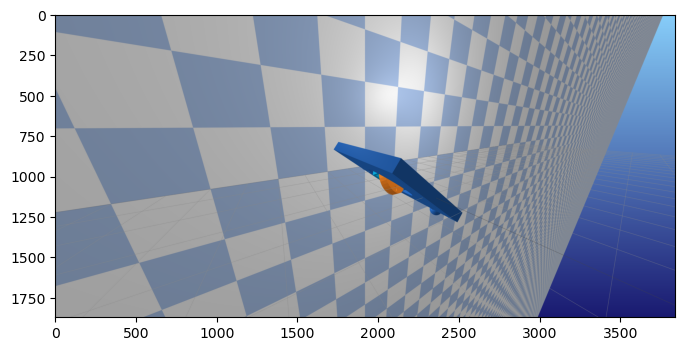

In [36]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

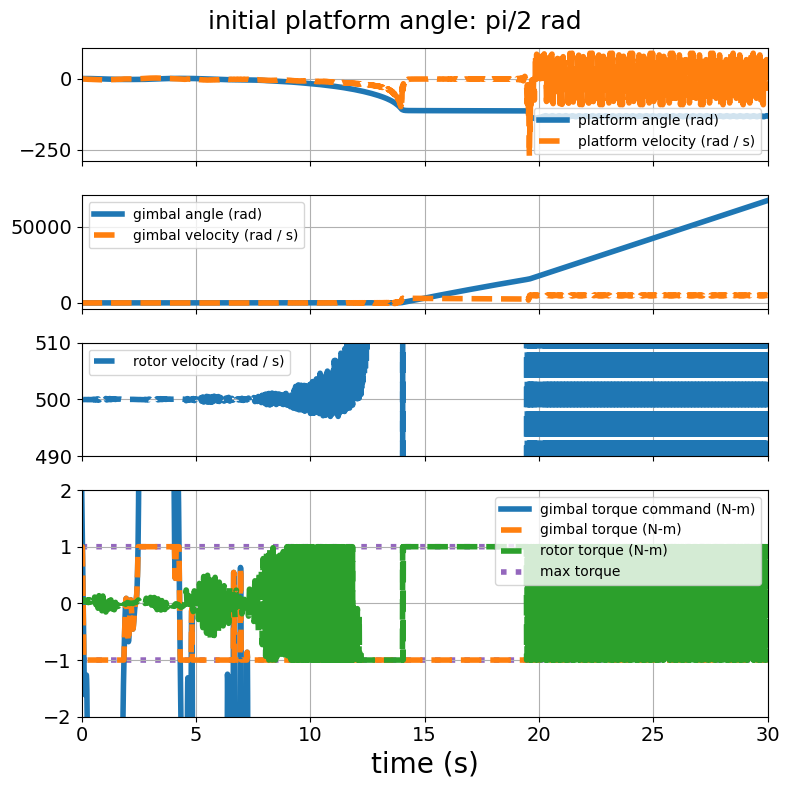

In [37]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_platform, ax_gimbal, ax_rotor, ax_torque) = plt.subplots(4, 1, figsize=(8, 8), height_ratios = [1,1,1,2], sharex=True)

fig.suptitle('initial platform angle: pi/2 rad', fontsize = 18)
# Plot platform angle and velocity
ax_platform.plot(
    data['t'], data['platform_angle'],
    label='platform angle (rad)', linewidth=4,
)
ax_platform.plot(
    data['t'], data['platform_velocity'],
    '--', label='platform velocity (rad / s)', linewidth=4,
)
ax_platform.grid()
ax_platform.legend(fontsize=10, loc='lower right')
ax_platform.tick_params(labelsize=14)


# Plot gimbal angle and velocity
ax_gimbal.plot(
    data['t'], data['gimbal_angle'],
    label='gimbal angle (rad)', linewidth=4,
)
ax_gimbal.plot(
    data['t'], data['gimbal_velocity'],
    '--', label='gimbal velocity (rad / s)', linewidth=4,
)
ax_gimbal.grid()
ax_gimbal.legend(fontsize=10)
ax_gimbal.tick_params(labelsize=14)

# Plot rotor velocity
ax_rotor.plot(
    data['t'], data['rotor_velocity'],
    '--', label='rotor velocity (rad / s)', linewidth=4,
)
ax_rotor.grid()
ax_rotor.legend(fontsize=10)
ax_rotor.tick_params(labelsize=14)
ax_rotor.set_ylim(simulator.rotor_velocity - 10., simulator.rotor_velocity + 10.)

# Plot torques
ax_torque.plot(
    data['t'], data['gimbal_torque_command'],
    label='gimbal torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['gimbal_torque'],
    '--', label='gimbal torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['rotor_torque'],
    '--', label='rotor torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', label='max torque', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=10, loc='upper right')
ax_torque.tick_params(labelsize=14)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])
ax_torque.set_ylim(-2 * simulator.tau_max, 2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

In [38]:
fig.savefig('pi-over-2.png', facecolor='white', transparent=False)